## Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot


## Cargamos una imagen de ejemplo para ver la operación de convolución

In [2]:
# desde colab

from google.colab import drive
drive.mount("/content/drive")


MessageError: ignored

La variable img es del tipo:  <class 'numpy.ndarray'>
Los números son del tipo:  uint8
Sus dimensiones son:  (300, 500, 3)


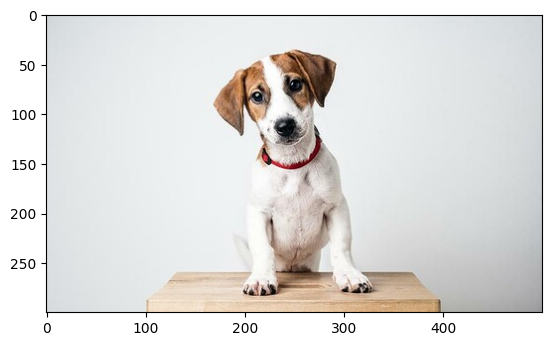

In [3]:
# load and display an image with Matplotlib

# load image as pixel array
img = image.imread('perro.jpg')
#img = image.imread('/content/drive/My Drive/CIA_marcos/deep_learning/clase_5/perro.jpg')

# summarize shape of the pixel array
print('La variable img es del tipo: ', type(img))
print('Los números son del tipo: ', img.dtype)
print('Sus dimensiones son: ', img.shape)

# display the array of pixels as an image
pyplot.imshow(img)
pyplot.show()

## Ejemplo de operación de convolución - Adaptación del formato requerido para pytorch



Documentacion de pytorch
`torch.nn.functional`

Los bloques `functional` ejecutan la operación matemática indicada.

```
torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) → Tensor
```
**input** – input tensor of shape (batch, in_channels, iH, iW)

**weight** – filters of shape (out_channels, in_channels, kH, kW)

**bias** – optional bias tensor of shape (out_channels). Default: None

**stride** – the stride of the convolving kernel. Can be a single number or a tuple (sH, sW). Default: 1

**padding** –
implicit paddings on both sides of the input.
Can be a string {‘valid’, ‘same’}, single number or a tuple (padH, padW). Default: 0
padding='valid' is the same as no padding.
padding='same' pads the input so the output has the shape as the input.
However, this mode doesn’t support any stride values other than 1.



---
**output** - es un tensor de dimensiones (batch_size, out_channels, Hout, Wout)


### ATENCIÓN
size:
```
input.shape = [batch_size, n_channels_in, H_in, W_in]

output.shape = [batch_size, n_channels_out, H_out, W_out]
```
con:

$$ H\_out = \lfloor\frac{H\_in-kernel\_size+2*padding}{stride} +1 \rfloor$$

$$ W\_out = \lfloor\frac{W\_in-kernel\_size+2*padding}{stride} +1 \rfloor$$





#### Convertir la imágen en tensor con dimensiones (N, C_in, H, W) (batch_size, n_chanels, height, width)

shape tensor from numpy
torch.Size([300, 500, 3])
------------------------


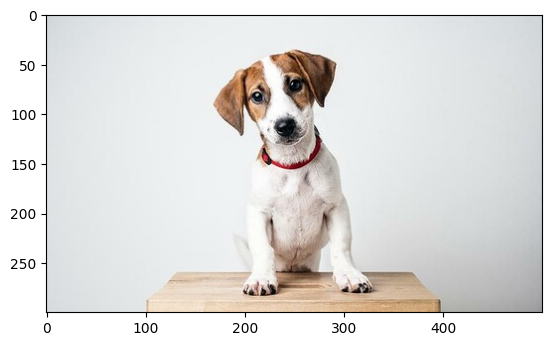

------------------------
se agrega la dimension del batch size
torch.Size([1, 300, 500, 3])
------------------------
vemos dtype
torch.float32
------------------------
Nuevas dimensiones de tensor DESPUES agregar dim de batch, ordenar y formato de datos
[tamaño_batch, nro_canales, vert_pixeles, hor_pixeles] =  torch.Size([1, 3, 300, 500])
data type:  torch.float32


In [4]:
# creamos tensor, lo normalizamos (entre 0 y 1) y lo pasamos a float.
img_tensor = torch.from_numpy(img/255.).float()  # <- no hace copia
#img_tensor = torch.tensor(img)     # <- hace copia
print('shape tensor from numpy')
print(img_tensor.shape)
print('-'*24)

# veamos de tener al perrito aún con nosotros
pyplot.imshow(img_tensor)
pyplot.show()
print('-'*24)


# se agrega dimension del batch size
img_tensor = img_tensor.unsqueeze(0)                                             # IMPORTANTE
print('se agrega la dimension del batch size')
print(img_tensor.shape)
print('-'*24)
# vemos tipo de data type
print('vemos dtype')
print(img_tensor.dtype)

# reordenamos la información y convertimos a float (ya estaba convertido de antes)

img_tensor = img_tensor.permute(0, 3, 1, 2).float()                              # IMPORTANTE

# vemos como queda todo
print('-'*24)
print('Nuevas dimensiones de tensor DESPUES agregar dim de batch, ordenar y formato de datos')
print('[tamaño_batch, nro_canales, vert_pixeles, hor_pixeles] = ', img_tensor.shape )


print('data type: ', img_tensor.dtype)



#### Generamos un kernel para convolucionar

In [5]:
# generamos un kernel de dimension 3x3 y valores  de 1 (es un filtro "pasa todo"... no queremos detectar nada...)
# se agrega una escala para que el resultado siga estando acotado entre 0 y 1
# y así poder graficar la salida.

# RECORDAR QUE LA OPERACIÓN DE CONVOLUCIÓN APLICA A CADA CANAL
# ENTONCES LA DIMENSION DE LA IMAGEN DE ENTRADA SE DEBE CONOCER

n_ch_in = 3 # numero de canales de la entrada
ks = 5 # kernel size
ch_out = 1
k1= torch.ones(ch_out,n_ch_in,ks,ks)*torch.tensor(1/((ks*ks)*ch_out))
#k1= torch.rand(ch_out,n_ch_in,ks,ks)*torch.tensor(1/((ks*ks)*ch_out))
print(k1, k1.dtype)

tensor([[[[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]],

         [[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]],

         [[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]]]]) torch.float32


#### Calculamos ahora la convolución

In [6]:
salida = torch.nn.functional.conv2d(img_tensor, k1, stride=1, padding=0)
print('Tamaño de salida: ', salida.shape)
# elimino batch_size
salida = salida.squeeze()
print('Tamaño de salida squeeze: ', salida.shape)
dimension = salida.squeeze().dim()
if dimension >2:
  salida = salida.permute(1, 2, 0)
  print('Tamaño de salida re-ordenada: ', salida.shape)
  #salida = salida/torch.max(salida)


Tamaño de salida:  torch.Size([1, 1, 296, 496])
Tamaño de salida squeeze:  torch.Size([296, 496])


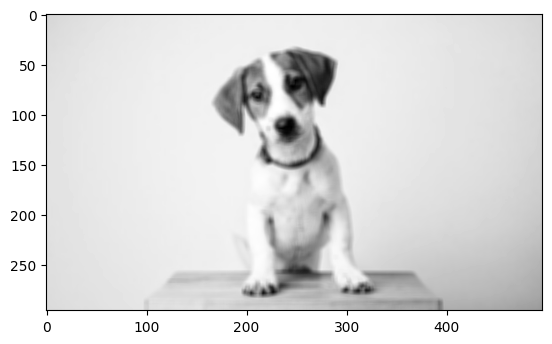

In [7]:
# display the array of pixels as an image
pyplot.imshow(salida, cmap='gray')
pyplot.show()


## Ejemplo capa convolución

Documentación de pytorch
`torch.nn.Conv2d`

```
class
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```



**in_channels (int)** – Number of channels in the input image

**out_channels (int)** – Number of channels produced by the convolution

**kernel_size (int or tuple)** – Size of the convolving kernel

**stride (int or tuple, optional)** – Stride of the convolution. Default: 1

**padding (int, tuple or str, optional)** – Padding added to all four sides of the input. Default: 0

**padding_mode (string, optional)** – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

**bias (bool, optional)** – If True, adds a learnable bias to the output. Default: True

### **OJO!**

size:
```
input.shape = [batch_size, n_channels_in, H_in, W_in]

output.shape = [batch_size, n_channels_out, H_out, W_out]
```
con:

$$ H\_out = \lfloor\frac{H\_in-kernel\_size+2*padding}{stride} +1 \rfloor$$

$$ W\_out = \lfloor\frac{W\_in-kernel\_size+2*padding}{stride} +1 \rfloor$$


---
**output** es un objeto , ya que ```torch.nn.Conv2d``` es una clase.



#### Convolucion con k 3x3 y 1 canal (1 solo kernel)

In [8]:
# creamos 1 filtro (out_channels = 1) de tamaño 3x3
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 2)

# veamos sus pesos sinápticos
print('elementos (pesos sinápticos) del kernel de la capa creada')
print(conv.weight)


# con eso se creó el objeto.. ahora hay que pasarle el tensor a convolucionar...
output = conv(img_tensor)

# dimensiones: (N, #filtros, H_out, W_out)
output.shape

elementos (pesos sinápticos) del kernel de la capa creada
Parameter containing:
tensor([[[[-0.2190,  0.1486],
          [-0.2870, -0.0490]],

         [[-0.0177, -0.1553],
          [-0.0688,  0.2449]],

         [[ 0.2403,  0.0818],
          [-0.0582,  0.2431]]],


        [[[ 0.1640, -0.1786],
          [-0.1613,  0.1304]],

         [[-0.0356,  0.2800],
          [-0.2849, -0.0696]],

         [[ 0.0916, -0.1967],
          [-0.0226, -0.1842]]],


        [[[-0.0141,  0.1529],
          [ 0.0572, -0.1805]],

         [[-0.0554, -0.0334],
          [-0.0450, -0.1259]],

         [[-0.2533,  0.1115],
          [-0.2592,  0.1254]]],


        [[[ 0.1527, -0.0594],
          [-0.2391, -0.2352]],

         [[-0.0915,  0.0475],
          [-0.2363, -0.1934]],

         [[ 0.0996, -0.1426],
          [ 0.2055, -0.1946]]]], requires_grad=True)


torch.Size([1, 4, 299, 499])

Tamaño de salida squeeze:  torch.Size([4, 299, 499])
Tamaño de salida re-ordenada:  torch.Size([299, 499, 4])


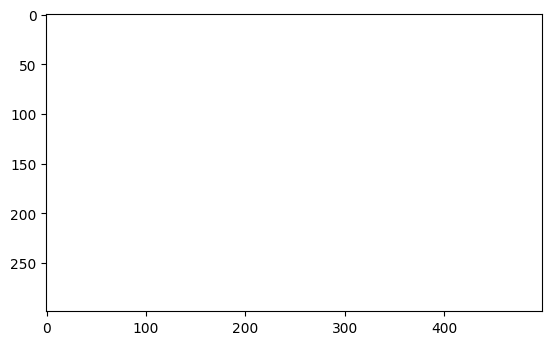

In [9]:
# elimino batch_size
salida = output.squeeze()
print('Tamaño de salida squeeze: ', salida.shape)
dimension = salida.squeeze().dim()
if dimension >2:
  salida = salida.permute(1, 2, 0)
  print('Tamaño de salida re-ordenada: ', salida.shape)
  #salida = salida/torch.max(salida)

# display the array of pixels as an image
pyplot.imshow(salida.detach().numpy(), cmap='gray')
pyplot.show()

In [10]:
# podemos ver los elementos de su kernel
conv.weight

Parameter containing:
tensor([[[[-0.2190,  0.1486],
          [-0.2870, -0.0490]],

         [[-0.0177, -0.1553],
          [-0.0688,  0.2449]],

         [[ 0.2403,  0.0818],
          [-0.0582,  0.2431]]],


        [[[ 0.1640, -0.1786],
          [-0.1613,  0.1304]],

         [[-0.0356,  0.2800],
          [-0.2849, -0.0696]],

         [[ 0.0916, -0.1967],
          [-0.0226, -0.1842]]],


        [[[-0.0141,  0.1529],
          [ 0.0572, -0.1805]],

         [[-0.0554, -0.0334],
          [-0.0450, -0.1259]],

         [[-0.2533,  0.1115],
          [-0.2592,  0.1254]]],


        [[[ 0.1527, -0.0594],
          [-0.2391, -0.2352]],

         [[-0.0915,  0.0475],
          [-0.2363, -0.1934]],

         [[ 0.0996, -0.1426],
          [ 0.2055, -0.1946]]]], requires_grad=True)

#### Ahora padding `same`

In [11]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 1, kernel_size = 3, padding = 'same', stride = 1)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H_out, W_out)
output.shape

torch.Size([1, 1, 300, 500])

#### Ahora un mega-kernel [85x85]

In [14]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 1, kernel_size = 85, padding = 10, stride = 1)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H_out, W_out)
output.shape

torch.Size([1, 1, 236, 436])

Tamaño de salida squeeze:  torch.Size([236, 436])


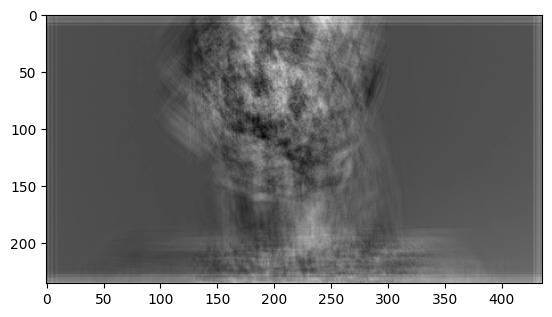

In [15]:
# elimino batch_size
salida = output.squeeze()
print('Tamaño de salida squeeze: ', salida.shape)
dimension = salida.squeeze().dim()
if dimension >2:
  salida = salida.permute(1, 2, 0)
  print('Tamaño de salida re-ordenada: ', salida.shape)
  #salida = salida/torch.max(salida)

# display the array of pixels as an image
pyplot.imshow(salida.detach().numpy(), cmap='gray')
pyplot.show()

#### Convolución padding y stride
`padding` controls the amount of padding applied to the input. It can be either a string **{‘valid’, ‘same’}** or **a tuple of ints** giving the amount of implicit padding applied on both sides.

`stride`  controls the stride for the cross-correlation, a **single number or a tuple**.




In [16]:
# agregando a mano el padding

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 7, kernel_size = 3, padding = 1)
output = conv(img_tensor)
# dimensiones: (N, #filtros, H_out, W_out)
output.shape

torch.Size([1, 7, 300, 500])

In [17]:
# modificando el paso (stride) de la operación
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 7, kernel_size = 3, padding = 1, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H_out, W_out)
output.shape

torch.Size([1, 7, 150, 250])

# Pooling

Tambien está definida una funcion `torch.nn.functional.max_pool2d` que ejecuta la operación matemática o una clase `torch.nn.MaxPoll2d` que genera una capa de NN (hay otras pooling functions también).
Vamos ver la clase directamente.

De la documentación tenemos:


```
class
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
```
Parámetros


**kernel_size** – the size of the window to take a max over

**stride** – the stride of the window. **Default value is kernel_size**

**padding** – implicit zero padding to be added on both sides

**dilation** – a parameter that controls the stride of elements in the window

**return_indices** – if True, will return the max indices along with the outputs. Useful for torch.nn.MaxUnpool2d later

**ceil_mode** – when True, will use ceil instead of floor to compute the output shape


---



**output** es un objeto , ya que ```torch.nn.MaxPool2d``` es una clase.


In [18]:
# creo el objeto (capa) de pooling
pool = torch.nn.MaxPool2d(10, padding=0)                             # ver: stride, otras pooling functions
#pool = torch.nn.MaxPool2d(10, padding=0, stride=10)
#pool = torch.nn.MaxPool2d(10, padding=0, stride=5)
#pool = torch.nn.AvgPool2d(5, padding=0, stride=5)

# le paso una imagen (el perrito!)
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 30, 50])

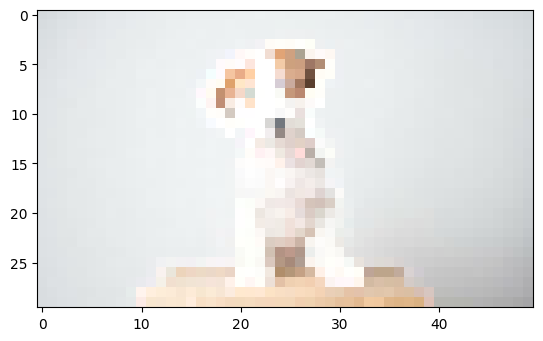

In [19]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

# Ejercicio - cálculo de dimensiones

Implemente con las clases de `conv2d` y `MaxPool2d` los siguientes casos:

#### ejercicio a)
Implemente una capa de convolución de 1 canal de entrada y salida,  con kernel de tamaño 5 y un padding que conserve el tamaño de la imagen; seguido de una capa de pooling que reduzca en la mitad las dimensiones de la imagen.

#### ejercicio b)
Implemente una capa de convolución de 10 canales con kernel de tamaño 5, un padding de 0 y stride para que el kernel no se pise a si mismo.

¿cual es le tamaño final de la salida, si entra una imagen de 200x100x3?

#### ejercicio c)
Implemente 3 capas de convolución en cascada, cada una con kernel size de 7, numero de canales de salida de [8, 16, 32] respectivamente y, con padding de 0. Al final, coloque una capa de pooling con kernel del 7, con un stride para que no se pisen a si mismo.

¿cual es le tamaño final de la salida, si entra una imagen de 500x500x1?

¿cual es el número de parámetros entenables?

#### ejercico d)
Si tiene una imagen a procesar de 300x200x3 y desea aplicar 3 capas de convolución+pooling en cascada con las siguientes características:

* kernel convolución = 5
* padding convolución = 0
* stride convolución = 1
* canales conv1 = 16
* canales conv2 = 32
* canales conv3 = 64

* kernel pooling = 2
* padding pooling = 0
* stride pooling = 2

¿cual es el tamaño final de la salida y cuantos canales tiene?

Si tiene que conectar esa salida a una `fully_connected` para clasificar 10 clases ¿que tamaño debe tener?

¿Cúal es el número total de parámetros a entrenar (contando la `fc`)?